In [ ]:
# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#Image FIltering
import cv2
import imghdr

In [5]:
data_dir='data'

In [6]:
image_exts=['jpeg', 'jpg', 'png', 'bmp']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
#Loading data
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 430 files belonging to 2 classes.


In [10]:
#Converting into numpy iterator
data_iterator = data.as_numpy_iterator()

In [11]:
#next batch of data
batch = data_iterator.next()


In [12]:
# 1: Himalayan Monal
# 2: Crow

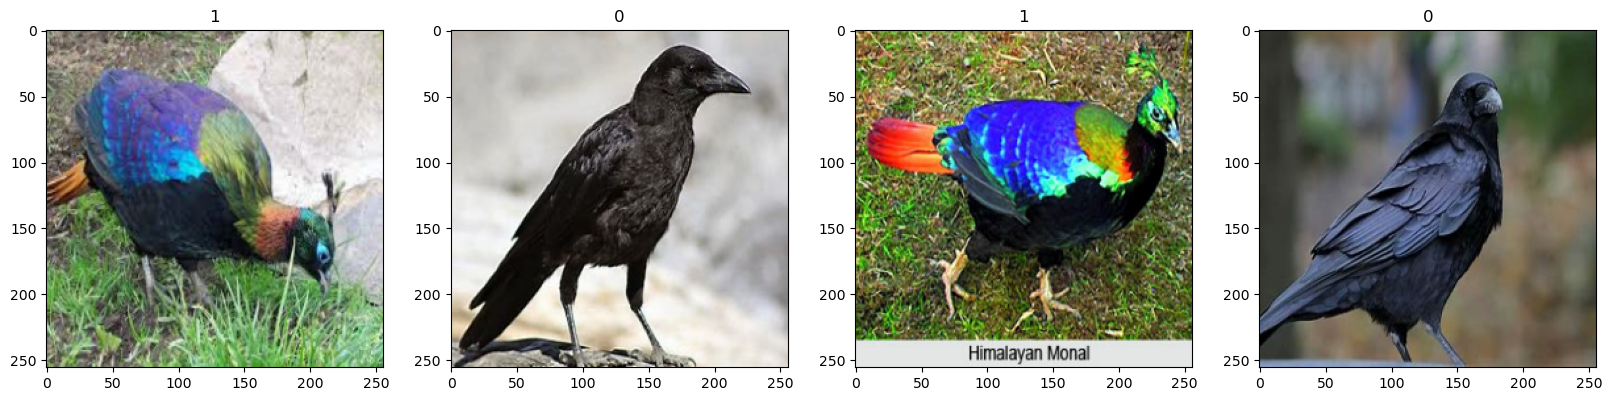

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
batch[0].max()

255.0

In [15]:
#scale data
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()

1.0

In [40]:
#splitting data
total_size = len(data)
train_size = int(total_size * 0.7)+1
val_size = int(total_size * 0.2)+1
test_size =int(total_size*0.1)

In [43]:
val_size+test_size+train_size


14

In [45]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [48]:
#Building deep learning model

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [53]:
model=Sequential()

In [54]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 7s 357ms/step - loss: 0.7907 - accuracy: 0.6187 - val_loss: 0.5945 - val_accuracy: 0.6771
Epoch 2/20
10/10 [==============================] - 5s 347ms/step - loss: 0.5672 - accuracy: 0.6875 - val_loss: 0.4773 - val_accuracy: 0.8438
Epoch 3/20
10/10 [==============================] - 5s 360ms/step - loss: 0.4169 - accuracy: 0.8406 - val_loss: 0.2512 - val_accuracy: 0.8958
Epoch 4/20
10/10 [==============================] - 5s 367ms/step - loss: 0.3613 - accuracy: 0.8406 - val_loss: 0.2194 - val_accuracy: 0.9479
Epoch 5/20
10/10 [==============================] - 5s 369ms/step - loss: 0.3020 - accuracy: 0.8969 - val_loss: 0.1786 - val_accuracy: 0.9688
Epoch 6/20
10/10 [==============================] - 5s 375ms/step - loss: 0.2558 - accuracy: 0.8813 - val_loss: 0.1328 - val_accuracy: 0.9792
Epoch 7/20
10/10 [==============================] - 6s 490ms/step - loss: 0.1324 - accuracy: 0.9625 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 

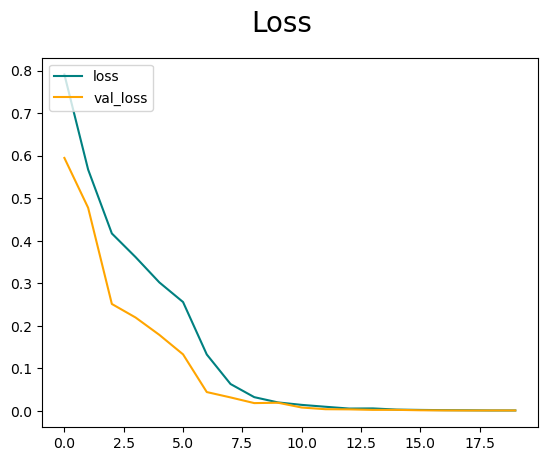

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

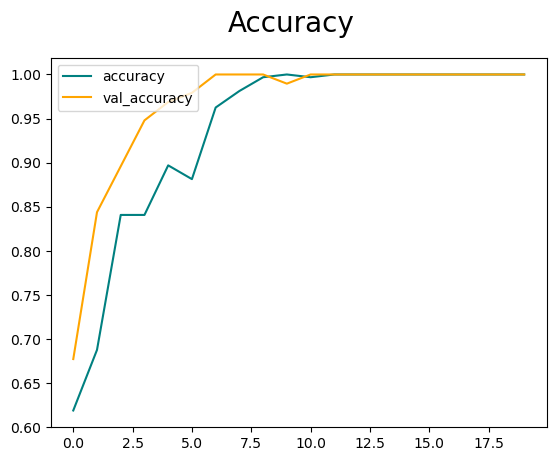

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [62]:
# Performance evaluation
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [71]:
print(f'PRECISION:{pre.result().numpy()}')
print(f'Accuracy:{acc.result().numpy()}')
print(f'Recall:{re.result().numpy()}')


PRECISION:1.0
Accuracy:1.0
Recall:1.0


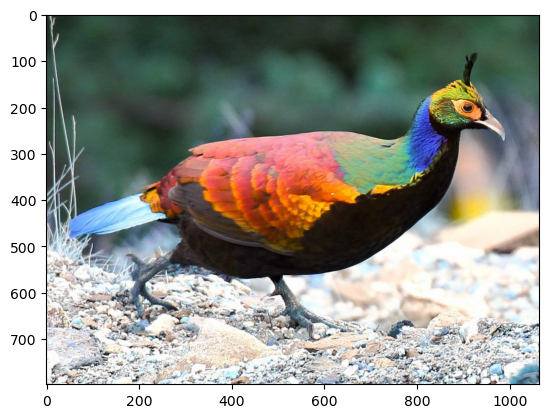

In [84]:
img = cv2.imread('danfe.jpg')
plt.imshow(img)
plt.show()

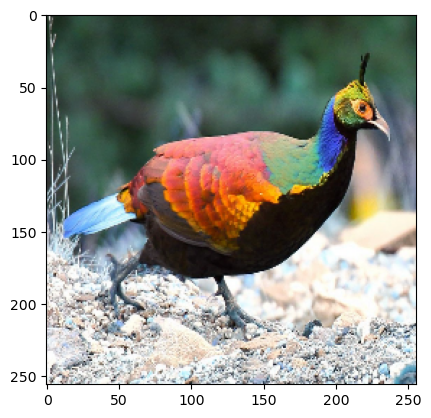

In [85]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [86]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [87]:
yhat

array([[0.990606]], dtype=float32)

In [88]:
if yhat > 0.5: 
    print(f'Predicted class: Himalayan Monal')
else:
    print(f'Predicted class: Crow')

Predicted class: Himalayan Monal


In [89]:
#Saving the training model
from tensorflow.keras.models import load_model

In [90]:
model.save(os.path.join('models','imageclassifier.h5'))

In [93]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [94]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.990606]], dtype=float32)